# A computational account of threat-related attentional bias

## Behavioural modelling

This notebook prepares the behavioural data before fitting computational models to subjects' responses.

> **_Note:_**  Some results here may differ _slightly_ from those reported in the paper. This is due to randomness in the analysis pipeline (and my inability to set random seeds properly in PyMC3) - this version of the notebook was run after the paper was written.


In [1]:
import os
import sys
import re
sys.path.insert(0, '../code') 
import copy
import pymc3 as pm
import pandas as pd
import numpy as np
import os
import dill
from tqdm import tqdm
from DMpy import DMModel, Parameter
from DMpy.utils import beta_response_transform
from modelling_functions import combine_behavioural, save_simulated, plot_param_values
from learning_models import leaky_beta, leaky_beta_asymmetric, rescorla_wagner, dual_lr_qlearning, pearce_hall_1, pearce_hall_2
from scipy.stats import ttest_rel
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
prop = font_manager.FontProperties(fname="C:\WINDOWS\Fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

# Random seed
np.random.seed(123)

# Colour palette for plotting
pal = ['#267fd3', '#e88300', '#b21724', '#053c5e']

## Load the data

Here we take every subject's behavioural data and combine them into one file with all the necessary information for modelling. Here we also exclude subjects who provide limited ratings (i.e. only using 0%, 50% or 100%) and any who we do not have full behavioural data for.

In [2]:
data_dir = '../data/behavioural_data'
combined_data, df = combine_behavioural(data_dir, file_regex='[0-9]{2}_behavioural.+', subject_regex='[0-9]{2}')

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.30it/s]


Excluded subjects: ['24', '31']
Saved combined data to ../data/behavioural_data\uncertainty_attention_shock_combined.csv
Mean shock level = 222.841269841


This gives us a dataframe containing data for every trial of every run for each subject. Outcomes are coded as 1 for shock and 0 for no shock.

In [3]:
df.head()

,Response,Outcome,Outcome_2,Objective_prob_A,Objective_prob_B,Run,Subject
0,0.500000,0.0,1.0,0.2,0.2,0,00
1,0.500000,1.0,0.0,0.2,0.2,0,00
2,0.557183,0.0,0.0,0.2,0.2,0,00
3,0.557183,0.0,0.0,0.2,0.2,0,00
4,0.557183,0.0,0.0,0.2,0.2,0,00


# Modelling

All modelling here is performed using [DMpy](https://github.com/tobywise/DMpy), a package for fitting learning and decision models in Python which is currently barely functional and untested - it works for this specific project but doesn't do much else so use at your own risk.

## Exclusions

A minority of subjects choose to follow a gambler's fallacy-like strategy (i.e. indicating that if they've just had a shock it's very unlikely they'll receive one again). As we're interested in how people learn to track probabilities, we need to exclude subjects who don't do this. We can detect this behaviour by fitting simple reinforcement learning models and allowing the learning rate to be negative, as this leads to behaviour where a shock results in a decreased shock probability estimate.

### Rescorla-Wagner model

This is a simple temporal difference learning model:

\begin{equation*}
Q_{t+1}^A = Q_t^A + \alpha\cdot(outcome^A - Q_t^A)
\end{equation*}

Where $A$ represents one of the stimuli. Here we let the $\alpha$ parameter take any value from -1 to 1 (normally we'd restrict this to positive values as a negative learning rate doesn't make much sense).

Additionally, both of these models account for potential influence of the other stimulus shown on the screen. This is factored into the estimated value on each trial by calculating a prediction error between the estimated value of stimulus $A$ (after the initial update) and the outcome of stimulus $B$, and weighting this by a second learning rate $\omega$.

\begin{equation*}
Q_{t+1}^A = Q_{t+1}^A + \omega\cdot(outcome^B - Q_{t+1}^A)
\end{equation*}

In [4]:
# Value parameter
value = Parameter('value', 'fixed', mean=0.5, dynamic=True)
# Learning rate parameter
alpha = Parameter('alpha', 'uniform', lower_bound=-1, upper_bound=1)
# Influence of the other stimulus
omega = Parameter(r'$\omega$', 'uniform', lower_bound=0, upper_bound=1)
# Set up Rescorla-Wagner model
rescorla_wagner_model = DMModel(rescorla_wagner, [value, alpha, omega], None, None, name='Rescorla-Wagner', logp_function='beta')

### Dual learning rate model

As a second check, we'll fit a dual learning rate model, which uses separate learning rates for positive and negative preciction errors ($\alpha^+$ and $\alpha^-$ respectively)

Value on each trial is updated according to:

\begin{equation*}
\delta = outcome^A - Q_t^A
\end{equation*}

\begin{equation*}
Q_{t+1}^A = Q_t^A + \begin{matrix}
\alpha^+ \cdot \delta&\text{if } \delta > 0 \\
\alpha^- \cdot \delta&\text{if } \delta < 0
\end{matrix}
\end{equation*}

Again, both learning rates are allowed to take any value between -1 and 1 here.

In [5]:
# Positive and negative learning rates
alpha_p = Parameter('alpha_p', 'uniform', lower_bound=-1, upper_bound=1)
alpha_n = Parameter('alpha_n', 'uniform', lower_bound=-1, upper_bound=1)

# Create dual learning rate model instance
dual_lr_model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n, omega], None, None, name='Dual learning rate', logp_function='beta')

### Fit the models

We're using non-hierarchical fitting as we don't want any shrinkage here. Variational inference gives us uncertainty estimates so we can check whether a parameter estimate is "significantly" below zero - this is an issue because point estimates that are positive but close to zero may be slightly mis-estimated as slightly negative. We can check this using the highest posterior density (HPD) intervals - if the 97.5 HPD is below zero we can be reasonably confident that the subject has a negative learning rate.

We can then get the learning rate HPD intervals from both models and combine them into one dataframe, before checking whether any of the learning rate 97.5% HPDs are below zero.

In [6]:
rescorla_wagner_model.fit(combined_data, fit_method='variational', fit_kwargs={'n': 40000}, model_inputs=['Outcome_2'], plot=False, 
                          suppress_table=True, response_transform=beta_response_transform)
dual_lr_model.fit(combined_data, fit_method='variational', fit_kwargs={'n': 40000}, model_inputs=['Outcome_2'], plot=False, 
                  suppress_table=True, response_transform=beta_response_transform)

Loading multi-subject data with 61 subjects, 8 runs per subject
Loaded data, 61 subjects with 40 trials * 8 runs
Created model

-------------------Fitting model using ADVI-------------------

Performing non-hierarchical model fitting for 61 subjects


Average Loss = inf: 100%|████████████████████████████████████████████████████████| 40000/40000 [15:37<00:00, 42.70it/s]
Finished [100%]: Average Loss = -2,529.4


Done
Finished model fitting in 947.7275657 seconds
Loading multi-subject data with 61 subjects, 8 runs per subject
Loaded data, 61 subjects with 40 trials * 8 runs
Created model

-------------------Fitting model using ADVI-------------------

Performing non-hierarchical model fitting for 61 subjects


Average Loss = -4,204.9: 100%|███████████████████████████████████████████████████| 40000/40000 [14:22<00:00, 46.37it/s]
Finished [100%]: Average Loss = -4,204.9


Done
Finished model fitting in 873.7939701 seconds


In [7]:
hpd_estimates = pd.merge(rescorla_wagner_model.parameter_table[['Subject', 'hpd_97.5_alpha']],
                dual_lr_model.parameter_table[['Subject', 'hpd_97.5_alpha_p', 'hpd_97.5_alpha_n']], on='Subject')
exclusions = hpd_estimates.Subject[(hpd_estimates < 0).any(axis=1)].tolist()
print "Excluding subjects {0}".format(exclusions)
hpd_estimates[(hpd_estimates < 0).any(axis=1)]

Excluding subjects [0L, 1L, 3L, 6L, 7L, 10L, 12L, 14L, 21L, 22L, 37L, 54L, 57L]


,Subject,hpd_97.5_alpha,hpd_97.5_alpha_p,hpd_97.5_alpha_n
0,0,-0.006707,0.087638,0.011375
1,1,-0.003545,0.021065,-0.001491
3,3,-0.000296,0.029268,0.005049
6,6,-0.005312,0.192920,0.048396
7,7,-0.000530,0.409646,0.098385
10,10,-0.003327,0.274952,0.076685
12,12,-0.001318,0.372556,0.021537
14,14,-0.002310,0.194691,0.043654
21,21,0.070414,-0.002415,0.044165
22,22,-0.011414,0.086614,0.008416


Save the excluded subjects to a csv file

In [8]:
pd.DataFrame(exclusions, columns=['Subject']).to_csv('../data/exclusions.txt', index=False)

## Influence of the other stimulus on behaviour

Although subjects are informed that the stimuli are independent, it is possible that their estimate of stimulus X may nonetheless be influnced by the outcome received from stimulus Y. If this is the case, it will be important to account for it in modelling.

In [9]:
df_other_stim = df[~df['Subject'].astype(int).isin(exclusions)].copy()  # Exclude subjects

We need to shift the outcomes forward one trial to line them up with the subsequent response.

In [10]:
df_other_stim.loc[:, 'Outcome_2'] = np.roll(df_other_stim.loc[:, 'Outcome_2'], 1)

We need to calculate the change in rating from trial to trial, excluding the first trial in each block as there is no change here.

In [11]:
df_other_stim['change'] = df_other_stim['Response'].diff()
df_other_stim['trial_number'] = np.tile(np.arange(320), len(df_other_stim['Subject'].unique()))
df_other_stim = df_other_stim[df_other_stim['trial_number'] % 40 != 0]

Then, for each subject we calculate the difference in rating changes depending on whether the other stimulus was shocked or not.

In [12]:
diffs = np.zeros(len(df_other_stim.Subject.unique()))
abs_diffs = np.zeros(len(df_other_stim.Subject.unique()))
permuted_diffs = np.zeros((len(df_other_stim.Subject.unique()), 1000))
for n, sub in enumerate(tqdm(df_other_stim.Subject.unique())):
    temp_df = df_other_stim[df_other_stim['Subject'] == sub].copy()
    diffs[n] = temp_df['change'][temp_df['Outcome_2'] == 1].mean() - temp_df['change'][temp_df['Outcome_2'] == 0].mean()
    abs_diffs[n] = np.abs(temp_df['change'][temp_df['Outcome_2'] == 1].mean()) - np.abs(temp_df['change'][temp_df['Outcome_2'] == 0].mean())

    p_diffs = np.zeros(1000)
    for i in range(1000):
        temp_df['Outcome_2'] = temp_df['Outcome_2'].sample(frac=1).values
        permuted_diffs[n, i] = np.abs(temp_df['change'][temp_df['Outcome_2'] == 1].mean()) - np.abs(temp_df['change'][temp_df['Outcome_2'] == 0].mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [02:21<00:00,  2.92s/it]


We can then plot the distribution of these values across subjects.

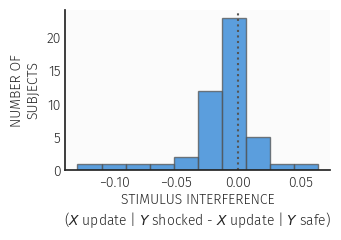

In [13]:
plt.figure(figsize=(3.5, 2.5), dpi=100)
plt.hist(diffs, color=pal[0], ec='#545454', alpha=0.75)
# plt.hist(permuted_diffs.mean(axis=1), color=pal[1], ec='#545454', alpha=0.75)


# Add a line to show the mean
plt.axvline(0, linestyle=':', color='#545454')

# Axes
sns.despine()
plt.xlabel("STIMULUS INTERFERENCE\n($X$ update | $Y$ shocked - $X$ update | $Y$ safe)", fontweight='light');
plt.ylabel("NUMBER OF\nSUBJECTS", fontweight='light')
plt.tight_layout()
plt.savefig('../figures/other_stimulus_influence.svg', facecolor='#fbfbfb')

And use the permuted results to test for significance

In [14]:
"Permutation p-value = {0}".format((np.mean(permuted_diffs, axis=0) >= np.mean(abs_diffs)).sum() / 1000.)

'Permutation p-value = 0.005'

## Model fitting and comparison

The next step is to define and fit the selection of models we're using. First we'll redefine the models used above to include slightly more informative priors, and to limit learning rates to sensible ranges.

In [15]:
# RESCORLA-WAGNER MODEL
# Estimated value, starting value fixed at 0.5
value = Parameter('value', 'fixed', mean=0.5, dynamic=True)

# Learning rate parameter, normally distributed between 0 and 1
alpha = Parameter('alpha', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Influence of the other stimulus, normally distributed between 0 and 1
omega = Parameter(r'$\omega$', 'normal', lower_bound=-0.5, upper_bound=0.5, mean=0, variance=5)

# Set up Rescorla-Wagner model
rescorla_wagner_model = DMModel(rescorla_wagner, [value, alpha, omega], None, None, name='Rescorla-Wagner', logp_function='beta')


# DUAL LEARNING RATE MODEL
# Positive and negative learning rates, normally distributed between 0 and 1
alpha_p = Parameter('alpha_p', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)
alpha_n = Parameter('alpha_n', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Create dual learning rate model instance
dual_lr_model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n, omega], None, None, name='Dual learning rate', logp_function='beta')


In addition to the two models defined above, we have three additional models.

### Hybrid Rescorla-Wagner / Pearce-Hall model

The dynamic learning rate model uses the same delta update rule as the Rescorla-Wagner model, however the learning rate ($\alpha$) is allowed to change over the course of the task according to the following rule:

\begin{equation*}
\alpha_{t+1}^X = \alpha_t^X + k \cdot (\delta^2 - \alpha_t^X)
\end{equation*}

Where $k$ is effectively the rate at which the learning rate updates.

In [16]:
# Learning rate parameter, normally distributed between 0 and 1
alpha_dynamic = Parameter('alpha', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5, dynamic=True)

k = Parameter('k', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

pearce_hall_1_model = DMModel(pearce_hall_1, [value, alpha_dynamic, k, omega], None, None, name='Pearce-Hall-1', logp_function='beta')

### Alternative hybrid Rescorla-Wagner / Pearce-Hall model

This model is taken from Tzovara et al., (2018, PLoS Computational Biology), and is in practice near identical to the above model except for using absolute prediction errors to update the learning rate rather than squared prediction errors.

The learning rate is updated on each trial as follows:

\begin{equation*}
\alpha_{t+1}^X = \alpha_t^X + k \cdot | \delta_{t} | + (1 - k) \cdot \alpha_{t}^X
\end{equation*}


In [17]:
pearce_hall_2_model = DMModel(pearce_hall_2, [value, alpha_dynamic, k, omega], None, None, name='Pearce-Hall-2', logp_function='beta')

### Leaky beta model

This model estimates the parameters of a beta distribution by increasing the value of $\alpha$ on shock outcomes and increasing the value of $\beta$ on no-shock outcomes at rate $\tau$. These values then decay at rate $\lambda$.

\begin{equation*}
a_{t+1}^X = (1 - \lambda) \cdot a_t^X + \tau \cdot outcome^X + \omega \cdot outcome^Y\\
b_{t+1}^X = (1 - \lambda) \cdot b_t^X + \tau \cdot (1 - outcome^X) + \omega \cdot (1 - outcome^Y)
\end{equation*}

Again, we model the influence of the other stimulus using $\omega$.

We then assume that subjects report the mean of this distribution:

\begin{equation*}
\mu = \frac{a}{a + b}
\end{equation*}

A benefit of this model is that we can also get an estimate of the subject's uncertainty around their probability estimate (which corresponds to estimation uncertainty or reducible uncertainty) by taking the variance of the beta distribution:

\begin{equation*}
\sigma = \frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}
\end{equation*}

While this isn't necessary for model fitting, it will come in handy later.

In [18]:
# Parameters of beta distribution - starting values fixed at 1
value = Parameter('value', 'fixed', mean=0.5, dynamic=True)
alpha = Parameter('alpha', 'fixed', mean=1, dynamic=True)
beta = Parameter('beta', 'fixed', mean=1, dynamic=True)

# Decay rate, normally distributed between 0 and 1
decay = Parameter(r'$\lambda$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Update weight for the standard leaky beta model, normally distributed between 0 and 1
tau = Parameter(r'$\tau$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Construct the model instance
leaky_beta_model = DMModel(leaky_beta, [value, alpha, beta, decay, omega, tau], None, None,
                               name='Leaky beta', logp_function='beta')

### Asymmetric leaky beta model

The final model we're using is a variant of the leaky beta model that allows for asymmetric updating - where updates in response to shock outcomes and no-shock outcomes happens at different rates. The update equations are similar to the standard model, but we instead use two $\tau$ parameters, one for shock outcomes ($\tau^+$) and one for no-shock outcomes ($\tau^-$).

\begin{equation*}
a_{t+1}^X = (1 - \lambda) \cdot a_t^X + \tau^+ \cdot outcome^X + \omega \cdot outcome^Y\\
b_{t+1}^X = (1 - \lambda) \cdot b_t^X + \tau^- \cdot (1 - outcome^X) + \omega \cdot (1 - outcome^Y)
\end{equation*}

In [19]:
# Positive and negative weights for the asymmetric model, normally distributed between 0 and 1
tau_p = Parameter(r'$\tau^+$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)
tau_n = Parameter(r'$\tau^-$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

leaky_beta_asymmetric_model = DMModel(leaky_beta_asymmetric, [value, alpha, beta, decay, omega, tau_p, tau_n], None, None,
                               name='Asymmetric leaky beta', logp_function='beta')


In [20]:
models = [rescorla_wagner_model, dual_lr_model, pearce_hall_1_model, pearce_hall_2_model, leaky_beta_model, leaky_beta_asymmetric_model]

### Effect of the other stimulus

The model is fit separately for each stimulus (X and Y), and subjects are informed that the stimuli are independent, but it is possible that when updating the value of X, the outcome associated with Y may nonetheless have an effect. To check this, we'll try fitting the models with the $\omega$ parameter fixed at zero and compare the fit to those with a free $\omega$ parameter.

In [21]:
def fix_omega(model):
    """
    This function fixes the value of omega to zero
    """
    m = copy.deepcopy(model)
    for i in m.learning_parameters:
        if 'omega' in i.name:
            i.fixed = True
            i.mean = 0
    m.name += '_fixed_omega'
    return m

Create duplicate models with $\omega$ set to zero.

In [22]:
fixed_omega_models = []

for m in models:
    fixed_omega_models.append(fix_omega(m))

### Model fitting

We can then fit each of these models. For speed this is run on a cluster, so here we just save the models and fit them using separate code (code is located at `../code/fit_behavioural_model.py`)

In [23]:
for m in models + fixed_omega_models:
    with open(os.path.join('../data/models', m.name.replace(' ', '-')), "wb") as f:
        dill.dump(m, f)

### Model comparison

This gives us the Watanabe-Akaike Information Criterion (WAIC) score for each of the models, which we can compare to determine which provides the best fit to the data.

First we load the fitted model instances.

In [24]:
models = []

for m in tqdm([i for i in os.listdir('../data/models') if '_fit' in i and not 'fixation' in i]):
    with open(os.path.join('../data/models', m), 'rb') as f:
        models.append(dill.load(f))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.47it/s]


Reorder the models for plotting (they're currently alphabetical but we want to group them by family for plotting)

In [25]:
new_order = [10, 11, 2, 3, 6, 7, 8, 9, 4, 5, 0, 1]
all_models = [models[i] for i in new_order]
models = [i for i in all_models if not 'fixed_omega' in i.name]

### WAIC scores

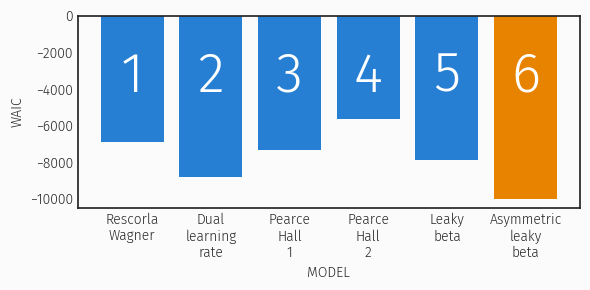

In [26]:
# Make things look nice
prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

# Plot the WAIC scores for each model
plt.figure(figsize=(6, 3), dpi=100, facecolor='#fbfbfb')
waic_pal = [pal[0]] * len(models)
waics = np.array([m.WAIC for m in models])
winning_idx = np.where(waics == waics.min())[0][0]
waic_pal[winning_idx] = pal[1]
plt.bar([m.name.replace(' ', '\n').replace('-', '\n') for m in models], waics, color=waic_pal)
plt.ylabel('WAIC', fontweight='light')
plt.xlabel("MODEL", fontweight='light')
text_y = waics.min() / 3
for i in range(len(models)):
    plt.text(i, text_y, i+1, size=40, ha='center', va='center', fontweight='light', color='#FFFFFF')
plt.tight_layout()


# Save the figure
plt.savefig('../figures/model_comparison.svg', facecolor='#fbfbfb')


The asymmetric leaky beta model clearly provides the best fit to the data. It's notable however that the second best fitting model is the dual learning rate model - clearly subjects seem to learn at different rates about positive and negative outcomes.

### Cross-validation

As an additional check, we cross-validate our models across blocks. This involves fitting the model on 3 blocks and then simulating data for each subject in the 4th block. We repeat this for all 4 combinations of fitting and testing blocks, and then calculate the $R^2$ value using our predicted responses and the true responses. Code for producing the simulated analyses is at `../code/fit_behavioural_model_cv.py`

In [27]:
model_dir = '../data/models'
r2_values = dict(model=[], r2=[])
for i in [i for i in os.listdir(model_dir) if 'block' in i]:
    temp_df = pd.read_csv(os.path.join(model_dir, i))
    r2_values['model'].append(re.search('.+(?=_cv)', i).group())
    r2_values['r2'].append(r2_score(temp_df['True_response'], temp_df['Response']))
r2_values = pd.DataFrame(r2_values)

In [28]:
r2_mean = r2_values.groupby('model').mean().reset_index()
r2_mean['order'] = [5, 1, 4, 2, 3, 0]
r2_mean = r2_mean.sort_values('order')
r2_mean = r2_mean[r2_mean.columns[:2]]
r2_mean

,model,r2
5,Rescorla-Wagner,0.412935
1,Dual-learning-rate,0.490857
3,Pearce-Hall-1,0.412766
4,Pearce-Hall-2,0.411425
2,Leaky-beta,0.434647
0,Asymmetric-leaky-beta,0.533680


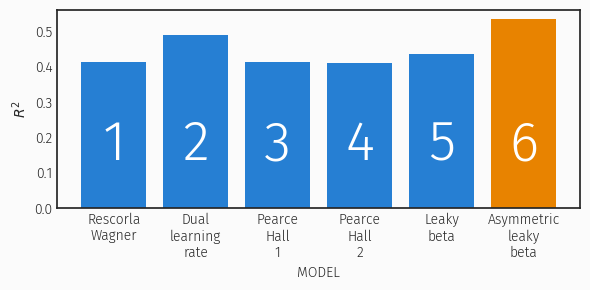

In [29]:
# Plot the WAIC scores for each model
plt.figure(figsize=(6, 3), dpi=100, facecolor='#fbfbfb')
r2_pal = [pal[0]] * len(models)
winning_idx = np.where(r2_mean['r2'] == r2_mean['r2'].max())[0][0]
r2_pal[winning_idx] = pal[1]
plt.bar([m.replace('-', '\n') for m in r2_mean['model']], r2_mean['r2'], color=r2_pal)
plt.ylabel('$R^2$', fontweight='light')
plt.xlabel("MODEL", fontweight='light')
text_y = r2_mean['r2'].max() / 3
for i in range(len(models)):
    plt.text(i, text_y, i+1, size=40, ha='center', va='center', fontweight='light', color='#FFFFFF')
plt.tight_layout()

# Save the figure
plt.savefig('../figures/model_comparison_r2.svg', facecolor='#fbfbfb')

Again, the asymmetric leaky beta model comes out on top.

### Comparing models with $\omega$ fixed at zero

Here we compare the standard models to a variant with $\omega$ (which represents the influence of the other stimulus on the estimation of the current stimulus) fixed at zero. This allows us to compare the full mode l to a model without any effect of the other stimulus.

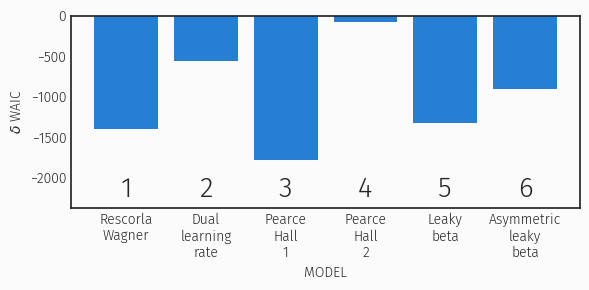

In [30]:
prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

# Plot the WAIC scores for each model
plt.figure(figsize=(6, 3), dpi=100, facecolor='#fbfbfb')
delta_waics = -np.diff(np.array([m.WAIC for m in all_models]).reshape((2, 6), order='F'), axis=0).squeeze()
winning_idx = np.where(delta_waics == delta_waics.min())[0][0]
waic_pal = [pal[0]] * len(delta_waics)
# waic_pal[winning_idx] = pal[1]
plt.bar([m.name.replace(' ', '\n').replace('_fixed_omega', '\n' + r'$\omega$=0').replace('-', '\n') for m in all_models[::2]], delta_waics, color=waic_pal)
plt.ylabel('$\delta$ WAIC', fontweight='light')
plt.xlabel("MODEL", fontweight='light')
text_y = delta_waics.min() + (delta_waics.min() / 5)
plt.ylim(delta_waics.min() + (delta_waics.min() / 3), 0)
for i in range(len(delta_waics)):
    plt.text(i, text_y, i+1, size=20, ha='center', va='center', fontweight='light')
plt.tight_layout()

# Save the figure
plt.savefig('../figures/model_comparison_omega.svg', facecolor='#fbfbfb')

### Parameter estimates

We can also look at the parameter estimates for all the subjects using our winning model to get an idea of their typical values and inter-individual variability.

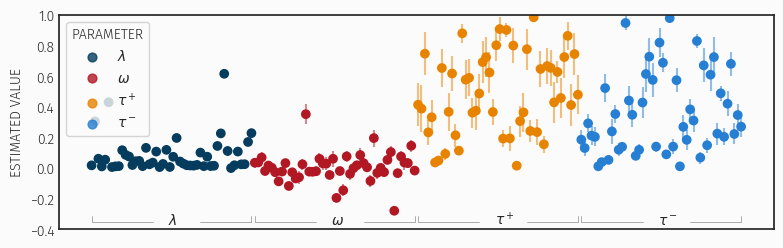

In [31]:
# Make things look nice
prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

# Get estimated parameter values
leaky_beta_asymmetric_model = models[-1]
param_values = leaky_beta_asymmetric_model.parameter_table

param_values_mean = param_values[[i for i in param_values.columns if 'mean' in i or 'Subject' in i]]
param_values_mean.columns = [i.replace('mean_', '') for i in param_values_mean.columns]
param_values_sd = param_values[[i for i in param_values.columns if 'sd' in i or 'Subject' in i]]
param_values_sd.columns = [i.replace('sd_', '') for i in param_values_sd.columns]

# Convert the dataframe from wide format to long format
param_values_long = pd.melt(param_values_mean, id_vars=['Subject'], value_name='mean')
param_values_sd_long = pd.melt(param_values_sd, id_vars=['Subject'])
param_values_long['sd'] = param_values_sd_long.value
param_values_long.columns = ['Subject', 'Parameter', 'Mean', 'SD']
param_values_long['var_name'] = param_values_long.Subject.astype(str).str.cat(param_values_long.Parameter, sep=' ')

param_values_long = param_values_long.sort_values(["Parameter", 'Subject'])
param_values_long['test'] = range(0, len(param_values_long))

# Set up a colour palette that will give us a different colour for every parameter
pal_extended = []
for i in pal:
    pal_extended += [i] * len(param_values_long.Subject.unique())

# Plot everything
f, ax = plt.subplots(1, 1, figsize=[8, 2.5], dpi=100, facecolor='#fbfbfb')
ax.scatter(param_values_long['test'][:], param_values_long.Mean, facecolors=pal_extended[::-1], label=None)
ax.errorbar(param_values_long['test'][:], param_values_long.Mean, yerr=param_values_long.SD, fmt='none',
             ecolor=pal_extended[::-1], alpha=0.5,
             c=pal_extended[::-1], label=None)

for n, i in enumerate(param_values_long.Parameter.unique()):
    ax.scatter([], [], alpha=0.8, s=40,
                label=str(i), c=pal[::-1][n])
    
# Legends and axes
ax.legend(scatterpoints=1, frameon=True, title='PARAMETER');
ax.set_ylabel("ESTIMATED VALUE", fontweight='light')

ax.set_xticks([])
ax.set_ylim(-0.4, 1)

# X axis labels
for n, p in enumerate(param_values_mean.columns[1:]):
    n_subs = len(param_values)
    ax.text((n_subs / 2 + n * n_subs) - 1.5, -0.37, p)
    line = plt.Line2D([n * n_subs, n * n_subs, n * n_subs + 18], [-0.31, -0.35, -0.35], color='#8c8c8c', linewidth=0.5)
    line.set_clip_on(False)
    line2 = plt.Line2D([n * n_subs + 32, n * n_subs + 47, n * n_subs + 47], [-0.35, -0.35, -0.31], color='#8c8c8c', linewidth=0.5)
    line2.set_clip_on(False)
    ax.add_line(line)
    ax.add_line(line2)

plt.tight_layout()

# Save
plt.savefig('../figures/estimated_parameter_values.svg', facecolor='#fbfbfb')


### Asymmetry in learning

It's notable that the $\tau^+$ estimates are far higher than the $\tau^-$ estimates, reflecting subjects' tendency to update their probability estimate to a greater extent after shock outcomes than after no-shock outcomes. To make this clearer, we can plot the distributions of the two parameters using a [raincloud plot](https://peerj.com/preprints/27137/).

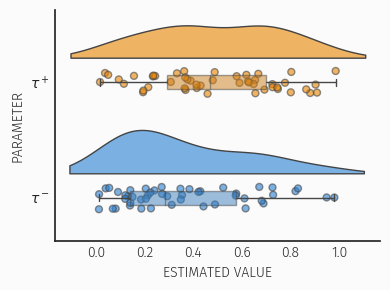

In [32]:
# Get tau values
tau_df = param_values[['mean_$\\tau^-$', 'mean_$\\tau^+$', 'Subject']]
tau_df = pd.melt(tau_df, id_vars='Subject', value_vars=[i for i in tau_df.columns if 'mean' in i],
                                                        value_name='Estimated value', var_name='Parameter')
tau_df['Parameter'] = tau_df['Parameter'].str.replace('mean_', '')

# Violin plot - this uses a fork of Seaborn that is capable of doing half-violin plots
plt.figure(figsize=(4, 3), dpi=100, facecolor='#fbfbfb')
violin = sns.violinplot(x='Estimated value', y="Parameter", data=tau_df, inner=None,
              jitter=True, color=".7", lwidth=0, width=0.6, offset=0.17, cut=1,
              linewidth=1, alpha=0.6, palette=pal, zorder=19);
for n, i in enumerate([i for i in violin.collections if isinstance(i, matplotlib.collections.PolyCollection)]):            
    plt.setp(i, facecolor=matplotlib.colors.colorConverter.to_rgba(pal[n], alpha=0.6))
    plt.setp(i, edgecolor=matplotlib.colors.colorConverter.to_rgba('#444444', alpha=1))

# Plot individual data points
sp = sns.stripplot(x='Estimated value', y="Parameter", data=tau_df, 
              jitter=0.08,
              linewidth=1, alpha=0.6, palette=pal, zorder=1);

# Boxplot
ax = sns.boxplot(x='Estimated value', y="Parameter", data=tau_df, 
                 palette=pal, whis=np.inf, linewidth=1,
           width=0.1, boxprops={"zorder":10, 'alpha':0.5}, whiskerprops={'zorder':10, 'alpha':1}, 
                 medianprops={'zorder':11, 'alpha':0.5});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
    
# Set up axes
plt.xlabel("ESTIMATED VALUE", fontweight='light');
plt.ylabel("PARAMETER", fontweight='light');
plt.yticks([0, 0.8])
plt.ylim([-0.3, 1.3])

# Make it look nice
sns.despine()
plt.tight_layout()

# Save
plt.savefig('../figures/tau_values.svg', facecolor='#fbfbfb')

We can use a t-test to test whether this difference is significant.

In [33]:
t, p = ttest_rel(leaky_beta_asymmetric_model.parameter_table['mean_$\\tau^+$'], 
                 leaky_beta_asymmetric_model.parameter_table['mean_$\\tau^-$'])

print "T({0}) = {1}\np = {2}".format(len(leaky_beta_asymmetric_model.parameter_table['mean_$\\tau^+$']) - 1, t, p)

T(47) = 6.90983602582
p = 1.1199262672e-08


Or take advantage of MCMC and look at overlap of the posterior densities for each parameter.

In [34]:
p = (m.trace['$\\tau^+$_group_mu'] - m.trace['$\\tau^-$_group_mu'] > 0).sum()
print "Tau_p was greater then tau_n in {0} / {1} samples ({2})".format(p, len(m.trace['$\\tau^-$_group_mu']), p / len(m.trace['$\\tau^-$_group_mu']))

Tau_p was greater then tau_n in 5900 / 6000 samples (0)


### Learning asymmetry in equal shock probability blocks

Here we fit the winning model to the blocks with an average of 50% shock probably to see whether the same bias in learning emerges when probabilities are approximately equal.

In [35]:
shock_prob_run = df.groupby(['Subject', 'Run']).mean().reset_index().sort_values(['Subject', 'Run']).reset_index()[['Subject', 'Run', 'Outcome']]
shock_prob_run.columns = ['Subject', 'Run', 'run_shock_prob_A']

In [36]:
df2 = pd.merge(df.reset_index(drop=True), shock_prob_run.reset_index(drop=True))
equal_shock_prob_df = df2[df2['run_shock_prob_A'] > 0.4].copy()

In [37]:
print("Average shock probability = {0}".format(equal_shock_prob_df['Outcome'].mean()))

Average shock probability = 0.5


In [38]:
for sub in equal_shock_prob_df.Subject.unique():
    equal_shock_prob_df.loc[equal_shock_prob_df.Subject == sub, 'Run'] = np.repeat([1, 2], 40)

In [39]:
leaky_beta_asymmetric_model.fit(equal_shock_prob_df.copy(), fit_method='variational', model_inputs=['Outcome_2'], exclude_subjects=exclusions,
  fit_kwargs={'n': 40000}, fit_stats=True, plot=False, hierarchical=True,
  response_transform=beta_response_transform, suppress_table=True)

Excluded subjects: [0L, 1L, 3L, 6L, 7L, 10L, 12L, 14L, 21L, 22L, 37L, 54L, 57L]
Loading multi-subject data with 61 subjects, 2 runs per subject
Loaded data, 61 subjects with 40 trials * 2 runs
Created model

-------------------Fitting model using ADVI-------------------

Performing hierarchical model fitting for 61 subjects


Average Loss = -1,102: 100%|█████████████████████████████████████████████████████| 40000/40000 [07:34<00:00, 87.98it/s]
Finished [100%]: Average Loss = -1,102.1


Done
WAIC = -10005.7725311
Finished model fitting in 482.1183649 seconds


In [40]:
shock_prob_param_values = leaky_beta_asymmetric_model.parameter_table[['mean_$\\tau^-$', 'mean_$\\tau^+$', 'Subject']]
shock_prob_param_values = pd.melt(shock_prob_param_values, id_vars=['Subject'], value_vars=[i for i in shock_prob_param_values.columns if 'mean' in i],
                                                        value_name='Estimated value', var_name='Parameter')
shock_prob_param_values['Parameter'] = shock_prob_param_values['Parameter'].str.replace('mean_', '')


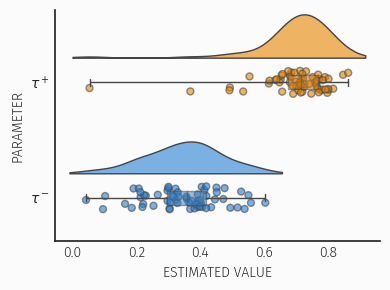

In [41]:
# Violin plot - this uses a fork of Seaborn that is capable of doing half-violin plots
plt.figure(figsize=(4, 3), dpi=100, facecolor='#fbfbfb')
violin = sns.violinplot(x='Estimated value', y="Parameter", data=shock_prob_param_values, inner=None,
              jitter=True, color=".7", lwidth=0, width=0.6, offset=0.17, cut=1,
              linewidth=1, alpha=0.6, palette=pal, zorder=19);
for n, i in enumerate([i for i in violin.collections if isinstance(i, matplotlib.collections.PolyCollection)]):            
    plt.setp(i, facecolor=matplotlib.colors.colorConverter.to_rgba(pal[n], alpha=0.6))
    plt.setp(i, edgecolor=matplotlib.colors.colorConverter.to_rgba('#444444', alpha=1))

# Plot individual data points
sp = sns.stripplot(x='Estimated value', y="Parameter", data=shock_prob_param_values, 
              jitter=0.08,
              linewidth=1, alpha=0.6, palette=pal, zorder=1);

# Boxplot
ax = sns.boxplot(x='Estimated value', y="Parameter", data=shock_prob_param_values, 
                 palette=pal, whis=np.inf, linewidth=1,
           width=0.1, boxprops={"zorder":10, 'alpha':0.5}, whiskerprops={'zorder':10, 'alpha':1}, 
                 medianprops={'zorder':11, 'alpha':0.5});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
    
# Set up axes
plt.xlabel("ESTIMATED VALUE", fontweight='light');
plt.ylabel("PARAMETER", fontweight='light');
plt.yticks([0, 0.8])
plt.ylim([-0.3, 1.3])

# Make it look nice
sns.despine()
plt.tight_layout()

# Save
plt.savefig('../figures/tau_values_equal_shock_probability.svg', facecolor='#fbfbfb')

### Other stimulus effect

Our model incorporates a parameter ($\omega$) that represents how much the other stimulus shown on the screen affects estimation of the current stimulus. Here we plot estimated $\omega$ values against the behavioural effect, i.e. difference between updates for when the other stimulus was shocked vs not shocked.

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


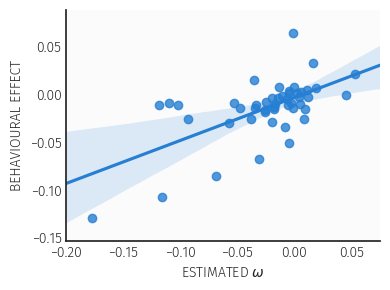

In [42]:
plt.figure(figsize=(4,3), dpi=100)
sns.regplot(models[0].parameter_table['mean_$\omega$'], np.array(diffs), color=pal[0])
plt.xlabel(r"ESTIMATED $\omega$", fontweight='light')
plt.ylabel("BEHAVIOURAL EFFECT", fontweight='light')
sns.despine()
plt.tight_layout()
plt.savefig('../figures/omega_interference_correlation.svg')

In [44]:
from scipy.stats import pearsonr
r, p = pearsonr(models[0].parameter_table['mean_$\omega$'], np.array(diffs))
print('R = {0}, p = {1}'.format(r, p))

R = 0.626915458344, p = 1.86603718429e-06


## Simulate data

Finally, we want to simulate data from the winning model with each subject's fitted parameter values to use in further analyses relating model-derived measures to eye tracking data and questionnaire measures. This is also an important step in checking the quality of the model fits - the simulated data should look reasonably similar to the observed behaviour.

First, we simulate trajectories of subjects' value estimates and variances (as a measure of uncertainty) using the winning model. These trial-by-trial values will be used to look at relationships with eye tracking measures.

In [55]:
models = []

for m in tqdm([i for i in os.listdir('../data/models') if '_fit' in i and not 'fixation' in i]):
    with open(os.path.join('../data/models', m), 'rb') as f:
        models.append(dill.load(f))

waics = np.array([m.WAIC for m in models])
winning_idx = np.where(waics == waics.min())[0][0]

leaky_beta_sim, _ = models[winning_idx].simulate(response_variable='value')

# Save simulated data to csv
save_simulated(leaky_beta_sim.results, save_dir='../data/simulated_data')

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.40it/s]


Simulating data from 384 sets of parameter values
Saving simulated results to 


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.40it/s]


We also need to output each subject's estimated parameter values and average value estimates and variances for analyses involving questionnaire measures.

In [56]:
# Calculate mean variance
mean_model_quantities = leaky_beta_sim.results.groupby('Subject').mean()
mean_model_quantities['Subject'] = leaky_beta_sim.results.Subject.unique()

# Save mean values and estimated parameters
leaky_beta_asymmetric_model.parameter_table.to_csv(os.path.join(data_dir, 'group_param_values.csv'), index=False)
mean_model_quantities.to_csv(os.path.join(data_dir, 'mean_model_quantities.csv'), index=False)


Finally we'll compare the simulated data from our model to some true data to see how it compares. Most computational models will have problems with the occasional subject who appears to be using a different strategy, but the fit should generally be good for most subjects. Here we'll plot a subjects showing a range of fitting success.

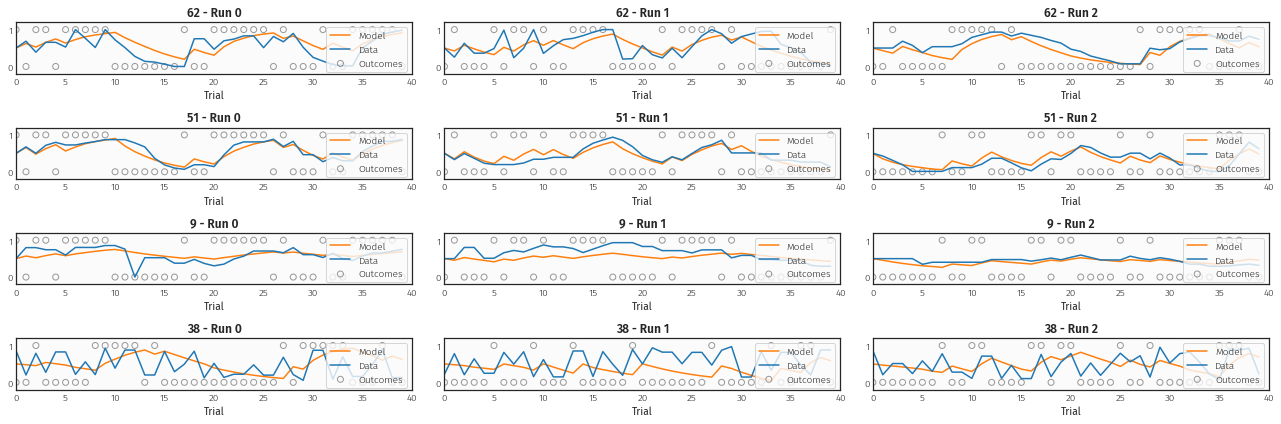

In [57]:
leaky_beta_sim.plot_against_true(subjects=[62, 51, 9, 38], runs=[0, 1, 2]);
plt.savefig('../figures/simulated_responses.svg', facecolor='#fbfbfb')

The model fits well for the first couple of subjects, slightly less well for the third, and doesn't seem to capture the behaviour of the fourth subject too well.

We'll make a nicer plot of one of the subjects.

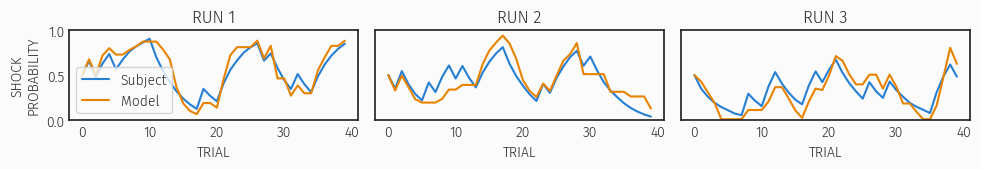

In [58]:
sub = 51

f, ax = plt.subplots(1, 3, figsize=(10, 1.8), dpi=100, facecolor='#fbfbfb')

temp_data = leaky_beta_sim.results[leaky_beta_sim.results.Subject == sub]
for run in [0, 1, 2]:
    ax[run].plot(temp_data.Response[temp_data.Run == run].values, color=pal[0], label='Subject')
    ax[run].plot(temp_data.True_response[temp_data.Run == run].values, color=pal[1], label='Model')
    ax[run].set_title("RUN {0}".format(run + 1), fontweight='light')
    ax[run].set_xlabel("TRIAL", fontweight='light')
    ax[run].set_ylim(0, 1)
    if run > 0:
        ax[run].set_yticklabels([])
    else:
        ax[run].set_ylabel("SHOCK\nPROBABILITY", fontweight='light')
        ax[run].legend(loc='lower left', frameon=True)
        
plt.tight_layout()
plt.savefig('../figures/example_subject_model_fit.svg', facecolor='#fbfbfb')

### Independence of value and uncertainty

This task aimed to manipulate aversive value (via shock probability) and uncertainty around this independently. However we don't have direct control over subjects' individual value and uncertainty estimates, so it's useful to check that we do indeed have uncorrelated values for these two quantities. We'll calculate the correlation between the two for each subject, and produce a density plot to show how these correlations are distributed.

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean R = -0.0692798943496 (0.331172942532)
T(65) = -1.68658816373, p = 0.096476952244


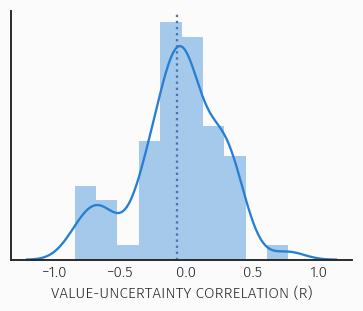

In [59]:
from scipy.stats import ttest_1samp

# Calculate correlations
simulated_dir = r'../data/simulated_data'
simulated_files = os.listdir(simulated_dir)
r_values = np.empty(len(simulated_files))
for n, sub in enumerate(simulated_files):
    temp_df = pd.read_csv(os.path.join(simulated_dir, sub))
    var = np.hstack([temp_df['A_var'], temp_df['B_var']])
    value = np.hstack([temp_df['A_True_response'], temp_df['B_True_response']])
    r_values[n] = np.corrcoef(var, value)[0, 1]

# Plot the distribution
plt.figure(figsize=(4, 3), dpi=110, facecolor='#fbfbfb')
sns.distplot(r_values, color=pal[0])

# Add a line to show the mean
plt.axvline(r_values.mean(), linestyle=':')

# Axes
sns.despine()
plt.xlabel("VALUE-UNCERTAINTY CORRELATION (R)", fontweight='light');
# plt.ylabel("DENSITY", fontweight='light');
plt.yticks([])
plt.savefig('../figures/value_variance_correlations.svg', facecolor='#fbfbfb')

print "Mean R = {0} ({1})".format(r_values.mean(), r_values.std())

t, p = ttest_1samp(r_values, 0)
print "T({0}) = {1}, p = {2}".format(len(r_values) - 1, t, p)

This demonstrates that, although there is some variability across subjects in the degree to which value and variance are correlated, the mean is almost exactly zero suggesting that we successfully independently manipulated the two. We should note however that some degree of correlation is not necessarily problematic as we will use a GLM testing for independent effects of each later on.